<a href="https://www.kaggle.com/kimimaru4411/streaming-platform-eda?scriptVersionId=88406631" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Loading Data and Libraries

First, we import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

Next, we load the streaming platform data and visualize it.

In [2]:
data_path = '../input/movie-project/MoviesOnStreamingPlatforms_updated.csv'
df = pd.read_csv(data_path)

In [3]:
df.head()

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,1,2,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,4,5,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [4]:
df.dtypes

Unnamed: 0           int64
ID                   int64
Title               object
Year                 int64
Age                 object
IMDb                object
Rotten Tomatoes     object
Netflix              int64
Hulu                 int64
Prime Video          int64
Disney+              int64
Type                 int64
Directors           object
Genres              object
Country             object
Language            object
Runtime            float64
dtype: object

## Data Preprocessing

The first column in our dataframe contains an unnecessary row id, so we start by removing it.
We then also remove the "Type" column, which contains nothing but zeroes.

In [5]:
df = df.drop(columns=['Unnamed: 0', 'Type'])

To check for the existence of missing values, we create a function that will return the number and percentage of missing values in each column of our dataframe.

In [6]:
def missing (df):
    missing_number = df.isna().sum().sort_values(ascending=False)
    missing_percent = (df.isna().sum()*100/df.isna().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [7]:
missing(df)

,Missing_Number,Missing_Percent
Age,4177,43.899107
Directors,411,4.319496
Runtime,319,3.352601
Language,313,3.289543
Country,254,2.669469
IMDb,206,2.165003
Genres,116,1.219128
Rotten Tomatoes,7,0.073568
ID,0,0.000000
Title,0,0.000000


We observe that 8 out of 15 columns contain missing values. The "Age" column in particular, which indicates the targeted age group for the movie, contains a very high percentage of missing values (nearly 44%).

Missing values are to be replaced with an empty string "", in the case of categorical columns. For numerical columns, we should replace missing values with zeroes. Since only 3 columns with numerical values contain missing values, it is simpler to replace missing values in all columns with an empty string and then replace empty strings with zeroes if the column type is numerical. The review score conventions for columns "IMDb" and "Rotten Tomatoes" were also normalized to an /10 format.

In [8]:
#We first replace all columns' missing values with an empty string
df.replace(np.nan,'',inplace=True)

#In numerical columns we place zeroes and convert review score columns to an /10 format

df['IMDb'] = df['IMDb'].str[:3].replace('','0').astype(float)
df['Rotten Tomatoes'] = df['Rotten Tomatoes'].str[:2].replace('','0').astype(float) / 10
df['Runtime'] = df['Runtime'].replace('',0).astype(float)

By running the previous function, we observe that there are no longer any missing values in the dataframe.

In [9]:
missing(df)

,Missing_Number,Missing_Percent
ID,0,0.0
Title,0,0.0
Year,0,0.0
Age,0,0.0
IMDb,0,0.0
Rotten Tomatoes,0,0.0
Netflix,0,0.0
Hulu,0,0.0
Prime Video,0,0.0
Disney+,0,0.0


Certain columns like "Genres" and "Country" often contain multiple comma separated categories. In order to obtain insights from this data such as, for example, the frequency count of each categorical value in the "Genres" column (i.e. Action,Sci-Fi,etc...), we must first convert it into a numeric format. 

To achieve this, each row value (for each column) was treated as a list of categories, and each unique category was one-hot-encoded into a separate column. This process was iterated for each column specified in the variable "cols_to_split" shown below. 

In [10]:
#Create a copy of the dataframe 
dfn = df

#We specify which columns to split
cols_to_split = ['Genres','Directors','Country','Language']

#Create list with all unique category values, to ensure that only one column is generated for each unique category
unique_values = []

for i, row in dfn.iterrows():
    for col in cols_to_split:
        values = row[col].split(',')
        for value in values:
            if value != '':
                if not col + '_' + value in unique_values:
                    unique_values.append(col + '_' + value)
                
#Create a dictionary populated only with zeroes for each unique column value                 
num_lines = dfn.shape[0]
one_hot_dict = {key : np.zeros(num_lines) for key in unique_values} 

#We now populate each dictionary column with 1 whenever a category matches said column 
for i, row in dfn.iterrows():
     for col in cols_to_split:
        values = row[col].split(',')
        for value in values:
            if value != '':
                dict_value = col + '_' + value
                one_hot_dict[dict_value][i] = 1
            
#Make a dataframe from the one-hot-encoded dictionary
one_hot_df = pd.DataFrame(one_hot_dict)

#Add the result to our existing dataset
df_encoded = pd.concat([dfn, one_hot_df], axis=1)

    

Now we can take a look at a portion of the encoded dataframe, reordering the columns alphabetically, to confirm that the one hot encoding was successful.

In [11]:
df1 = df_encoded.reindex(sorted(df_encoded.columns), axis=1)
df1.iloc[:,130:150].head()

,Country_Yugoslavia,Country_Zimbabwe,Directors,Directors_A. Bhimsingh,Directors_A. Edward Sutherland,Directors_A. Rajdeep,Directors_A. Salaam,Directors_A.J. Martinson,Directors_A.J. Mattioli,Directors_A.L. Vijay,Directors_A.R. Murugadoss,Directors_Aadish Keluskar,Directors_Aamir Khan,Directors_Aanand L. Rai,Directors_Aaron B. Koontz,Directors_Aaron Blaise,Directors_Aaron Cadieux,Directors_Aaron Courseault,Directors_Aaron Fronk,Directors_Aaron Hann
0,0.0,0.0,Martin Scorsese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,Nitesh Tiwari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,Ashutosh Gowariker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note also that the original column name was appended to each new category column name. This will help segment the data for the exploratory analysis.

## Exploratory Data Analysis

### Movie Genres

First off, let's compare how many movies of each genre are streamed across each platform.

In [12]:
#Create separate dataframes for each streaming platform
netflix_data = df_encoded[(df_encoded['Netflix'] == 1)]
hulu_data = df_encoded[(df_encoded['Hulu'] == 1)]
prime_data = df_encoded[(df_encoded['Prime Video'] == 1)]
disney_data = df_encoded[(df_encoded['Disney+'] == 1)]

In [13]:
# Int Vars
# Since the one-hot-encoded columns begin in column 15 and onward
col = 15 
# Aux int
count = 0 

# List of all columns in the encoded dataframe
list_of_cols = df_encoded.columns

g = [] #Genre list.

g_count = [[],[],[],[]] # Genre counts for each of the 4 platforms

plat_index = [netflix_data, hulu_data, prime_data, disney_data] #Index list
 
# For each one-hot-encoded genre column, we count the total of ocurrences and append it to our g_count list    
while count < len(g_count):
    col = 15
    while col < len(list_of_cols): 
        if 'Genres' in list_of_cols[col]:
            g_count[count].append(plat_index[count][list_of_cols[col]].sum())
            if count == 0:
                g.append(list_of_cols[col])
        col = col + 1
    count = count + 1 

# We then create a dataframe from each list of counts, for every streaming platform    
genre_count = pd.DataFrame(
    {'Genre': g,
     'Count of Netflix Movies': g_count[0],
     'Count of Hulu Movies': g_count[1],
     'Count of Prime Movies': g_count[2],
     'Count of Disney Movies': g_count[3]
    })

# We exclude the column which contains missing values, which were previously replaced with null values
genre_count = genre_count[genre_count['Genre'] != 'Genres_']

We can now visualize the frequency of each movie genre across diferent platforms.

In [14]:
genre_count.head()

,Genre,Count of Netflix Movies,Count of Hulu Movies,Count of Prime Movies,Count of Disney Movies
0,Genres_Biography,202.0,70.0,197.0,25.0
1,Genres_Crime,448.0,130.0,554.0,28.0
2,Genres_Drama,1679.0,509.0,1917.0,221.0
3,Genres_Action,614.0,186.0,712.0,125.0
4,Genres_Sport,118.0,32.0,111.0,59.0


In [15]:
#List of Genres
sorted(genre_count['Genre'].to_list())

['Genres_Action',
 'Genres_Adventure',
 'Genres_Animation',
 'Genres_Biography',
 'Genres_Comedy',
 'Genres_Crime',
 'Genres_Documentary',
 'Genres_Drama',
 'Genres_Family',
 'Genres_Fantasy',
 'Genres_Film-Noir',
 'Genres_Game-Show',
 'Genres_History',
 'Genres_Horror',
 'Genres_Music',
 'Genres_Musical',
 'Genres_Mystery',
 'Genres_News',
 'Genres_Reality-TV',
 'Genres_Romance',
 'Genres_Sci-Fi',
 'Genres_Short',
 'Genres_Sport',
 'Genres_Talk-Show',
 'Genres_Thriller',
 'Genres_War',
 'Genres_Western']

In [16]:
#Number of Genres
print(len(genre_count))

27


In [17]:
#Total movie counts across platforms (Netflix,Hulu,Prime Video,Disney+)
platform = ['Netflix','Hulu','Prime Video','Disney+']
i=0
mv_counts = []
for col in genre_count.columns[1:5]:
    print(platform[i] + ' movie count' + '\n' + str(genre_count[col].sum()))
    mv_counts.append(genre_count[col].sum())
    i+=1

Netflix movie count
8875.0
Hulu movie count
2828.0
Prime Video movie count
9847.0
Disney+ movie count
3357.0


Text(0.5, 1.0, 'Movie Count by Streaming Platform')

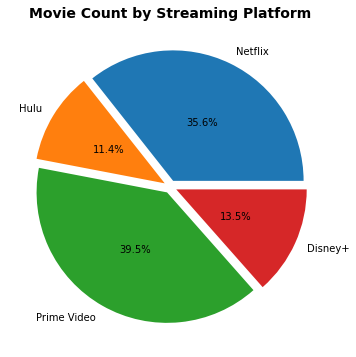

In [18]:
#Title font
title_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 14}

#We can create a pie chart using these values
pie, ax = plt.subplots(figsize=[10,6])
labels = platform
plt.pie(x=mv_counts, autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Movie Count by Streaming Platform", title_font)

From a first glance at this data, we can see that Netflix and Prime Video stream a lot more movies than Hulu and Disney+, so it would be interesting to know the distributed percentage of genres across each platform.

In [19]:
#We copy the totals from the previous dataframe to a new one, and divide each genre frequency count by the total number of genres.
genre_perc = genre_count.copy()

for col in genre_perc.columns[1:5]:
    total = genre_perc[col].sum()
    for i, row in genre_perc.iterrows():
        genre_perc.at[i,col] = (row[col] / total) * 100
        
genre_perc.columns = ['Genre','Percentage of Netflix Movies', 'Percentage of Hulu Movies', 'Percentage of Prime Movies', 'Percentage of Disney Movies']
genre_perc = genre_perc.round(4)        
        

Each value count was then translated into a percentage of movies within each platform.

In [20]:
genre_perc = genre_perc.sort_values(by=['Genre'])

In [21]:
genre_perc.head()

,Genre,Percentage of Netflix Movies,Percentage of Hulu Movies,Percentage of Prime Movies,Percentage of Disney Movies
3,Genres_Action,6.9183,6.5771,7.2306,3.7236
11,Genres_Adventure,4.0789,4.9505,3.9403,10.6047
17,Genres_Animation,2.7380,2.2277,1.2390,9.7706
0,Genres_Biography,2.2761,2.4752,2.0006,0.7447
10,Genres_Comedy,16.5972,11.6690,12.7044,14.0304


Using a stacked vertical barplot, the distribution of genre percentages between platforms can be shown for each of the 27 genres in this dataset.

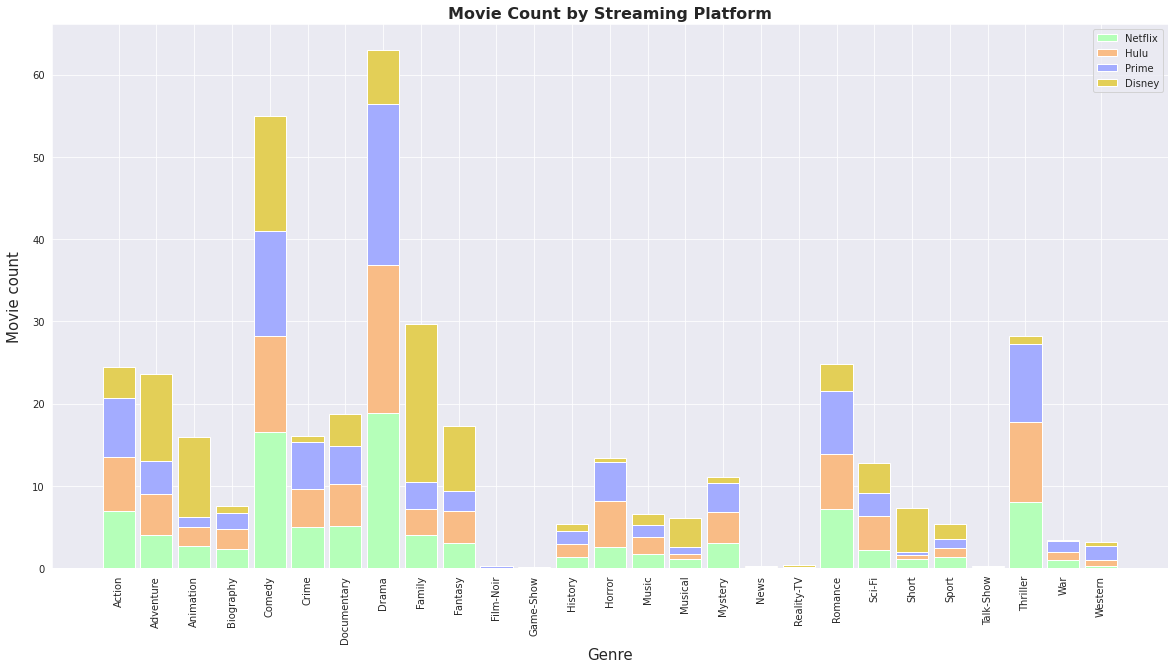

In [22]:
#Set style
sb.set_style("darkgrid")

#Set bar thickness
barWidth = 0.85

#Title font
title_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 16}
#Sub font
sub_font = {'family': 'sans-serif',
        'fontweight' : 'normal',
        'fontsize'   : 15}

#List of numerical positions of all 27 genres
r=list(range(0,27))

#Dataframe
plt_data = {'Netflix': genre_perc['Percentage of Netflix Movies'],
     'Hulu':genre_perc['Percentage of Hulu Movies'],
     'Prime': genre_perc['Percentage of Prime Movies'],      
     'Disney':genre_perc['Percentage of Disney Movies']
    }
#Groups
plt_index = genre_perc['Genre'].str[7:].to_list()

#Data
plot_dataframe = pd.DataFrame(data=plt_data, index=plt_index)


#Plot
plt.bar(r, plt_data['Netflix'], color='#b5ffb9', edgecolor='white', width=barWidth,label = 'Netflix')
plt.bar(r, plt_data['Hulu'],bottom = plt_data['Netflix'], color='#f9bc86', edgecolor='white', width=barWidth,label='Hulu')
plt.bar(r, plt_data['Prime'],bottom=[i+j for i,j in zip(plt_data['Netflix'],plt_data['Hulu'])], color='#a3acff', edgecolor='white', width=barWidth, label='Prime')
plt.bar(r, plt_data['Disney'],bottom=[i+j+k for i,j,k in zip(plt_data['Netflix'],plt_data['Hulu'],plt_data['Prime'])], color='#e3cf57', edgecolor='white', width=barWidth,label='Disney')

#Other plot settings
plt.title('Movie Count by Streaming Platform',title_font)
plt.xticks(r, plt_index)
plt.xticks(rotation=90)
plt.xlabel('Genre',sub_font)
plt.ylabel('Movie count',sub_font,labelpad=10.0)
plt.legend(loc='upper right')
fig = plt.gcf() 
fig.set_size_inches(20,10)

plt.show()

In this chart we can see, for example, how Netflix, Hulu and Prime Video mainly stream Drama, Comedy, Action and Thriller/Horror movies, as opposed to Disney+ which favours Family, Fantasy, Adventure and Animation movies much more. However, the overwhelming amount of information as well as the lack of data labels in this chart make it difficult to analyse.For this reason, this chart was narrowed down to only the most frequently ocurring genres in each platform.

We start by creating two lists, one containing the percentages of top n genres in each of the four platforms (top_list) and another containing the corresponding genre names for each sublist (g_list).

In [23]:
#list of values
top_list= [] 
#list of genres
g_list = [] 
#Desired number of top genres 
n_top=5 

for col in genre_perc.iloc[:,1:]:
    gp_sorted = genre_perc.sort_values(by=[col],ascending = False)
    top_list.append(gp_sorted[col].to_list()[:n_top])
    g_list.append(gp_sorted['Genre'].to_list()[:n_top])
    
print(top_list, g_list)

[[18.9183, 16.5972, 7.9887, 7.1887, 6.9183], [17.9986, 11.669, 9.7242, 6.6832, 6.5771], [19.4679, 12.7044, 9.5765, 7.647, 7.2306], [19.2136, 14.0304, 10.6047, 9.7706, 7.8642]] [['Genres_Drama', 'Genres_Comedy', 'Genres_Thriller', 'Genres_Romance', 'Genres_Action'], ['Genres_Drama', 'Genres_Comedy', 'Genres_Thriller', 'Genres_Romance', 'Genres_Action'], ['Genres_Drama', 'Genres_Comedy', 'Genres_Thriller', 'Genres_Romance', 'Genres_Action'], ['Genres_Family', 'Genres_Comedy', 'Genres_Adventure', 'Genres_Animation', 'Genres_Fantasy']]


In order to represent these percentages in a stacked bar plot, where the highest percentages of each platform appear on the
bottom of the graph, we must rearrange the values in each list using the following transformation.

In [24]:
values_list = []
ge_list = []
i=0
lst_aux = []
ge_aux = []

while i < n_top:
    j=0
    while j < 4:
        lst_aux.append(top_list[j][i])
        ge_aux.append(g_list[j][i])
        j+=1 
        
    values_list.append(lst_aux)
    ge_list.append(ge_aux)
    lst_aux = []
    ge_aux = []
    i+=1  
print(values_list,ge_list)    
       

[[18.9183, 17.9986, 19.4679, 19.2136], [16.5972, 11.669, 12.7044, 14.0304], [7.9887, 9.7242, 9.5765, 10.6047], [7.1887, 6.6832, 7.647, 9.7706], [6.9183, 6.5771, 7.2306, 7.8642]] [['Genres_Drama', 'Genres_Drama', 'Genres_Drama', 'Genres_Family'], ['Genres_Comedy', 'Genres_Comedy', 'Genres_Comedy', 'Genres_Comedy'], ['Genres_Thriller', 'Genres_Thriller', 'Genres_Thriller', 'Genres_Adventure'], ['Genres_Romance', 'Genres_Romance', 'Genres_Romance', 'Genres_Animation'], ['Genres_Action', 'Genres_Action', 'Genres_Action', 'Genres_Fantasy']]


Now that we can have obtained the values that go in each layer of the bar plot and the corresponding genre label, we can plot our graph.

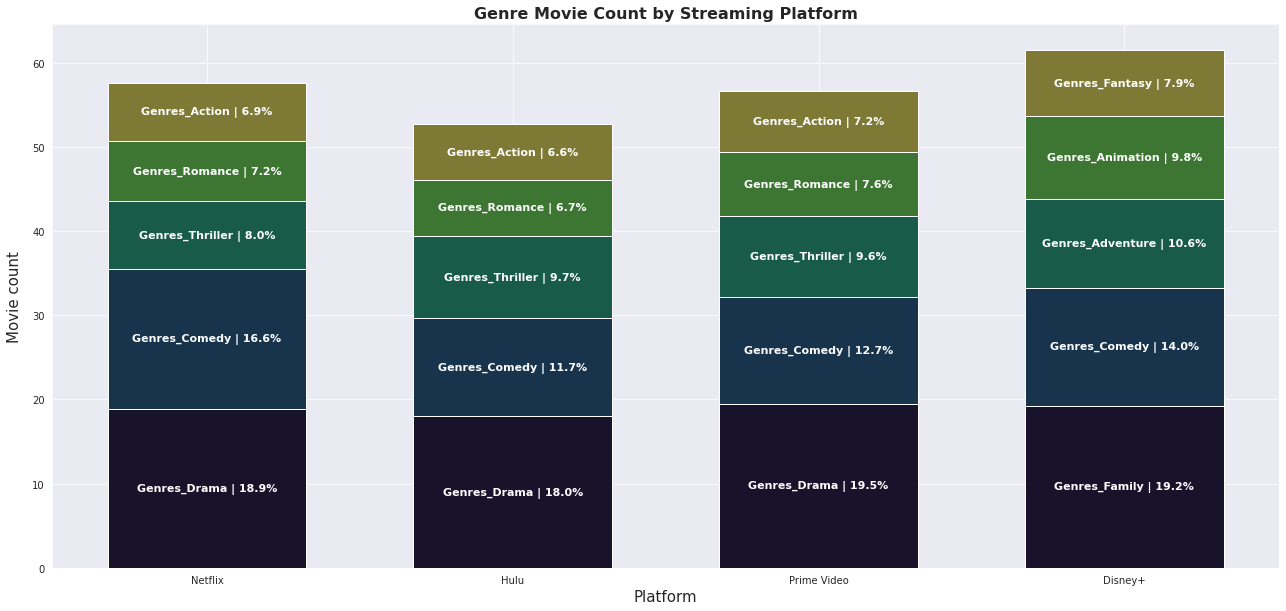

In [25]:
#Set style and palette
sb.set_style("darkgrid")
sb.set_palette("cubehelix",10)

#Bar width
wd = 0.65

#Groups
index = ['Netflix','Hulu','Prime Video','Disney+']

#Create stacked barplots
plt.bar(index, values_list[0],width = wd)
plt.bar(index, values_list[1], bottom = values_list[0],width = wd)

#Plot settings
fig = plt.gcf() 
fig.set_size_inches(22,10)

#Set fonts
title_font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 16}

sub_font = {'family': 'sans-serif',
        'fontweight' : 'normal',
        'fontsize'   : 15}

text_font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 11}

#Plot
plt.rc('font', **text_font) 
plt.title('Genre Movie Count by Streaming Platform',title_font)
plt.xlabel('Platform',sub_font)
plt.ylabel('Movie count',sub_font,labelpad=10.0)

n=0    
while n < (len(values_list) - 2):
    plt.bar(index, values_list[n+2],bottom = [sum(x) for x in zip(*values_list[:n+2])],width =wd)
    n = n + 1

#Add Percentage labels     
n_lst = []
n_lst.append(values_list[0]) 

i=0
for xpos, ypos, yval in zip(index, np.divide(values_list[0],2), values_list[0]):
        plt.text(xpos, ypos, ge_list[0][i] + ' | ' + "%.1f"%yval + '%', ha="center", va="center", color='white')
        i+=1     
m=1
i=0
while m < len(values_list):
    n_lst.append(values_list[m])
    yn = n_lst[m]
    ysum = [sum(x) for x in zip(*n_lst[0:m])]
    i=0
    for xpos, ypos, yval in zip(index, ysum + np.divide(yn,2), yn):
        plt.text(xpos, ypos, ge_list[m][i] + ' | ' + '%.1f'%yval + '%', ha='center', va='center',color='white')
        i+=1
       
    m=m+1  
       
plt.show()

In this visualization, it is much easier to tell which are the most streamed movie genres in each platform, which hint at the main target age groups chosen by each streaming platform.

### Age Group

Intuitively, we know that genres are sometimes associated with certain age groups, in the sense that you might not expect a drama movie to target audiences under 16 years old. However, taking the Comedy genre as example, there is no clear evidence of which age group is targeted by a specific movie's comedy. With this in mind, I decided to take a look at how targeted age groups vary across platforms.

Note: The missing values function used earlier concluded that over 40% of movie entries had no associated age group. As a result, this analysis will, most likely, not accurately reflect the distribution of age groups, but it will be done anyway for academic purposes. 

In [26]:
#Create a dataframe with the sum of ocurrences of each age group, in each platform, excluding missing values

netflix_age_grp = netflix_data['Age'].value_counts().rename_axis('Age_Group').reset_index(name='Netflix_Counts')
netflix_age_grp = netflix_age_grp[netflix_age_grp.Age_Group != '']

prime_age_grp = prime_data['Age'].value_counts().rename_axis('Age_Group').reset_index(name='Prime_Counts')
prime_age_grp = prime_age_grp[prime_age_grp.Age_Group != '']

hulu_age_grp = hulu_data['Age'].value_counts().rename_axis('Age_Group').reset_index(name='Hulu_Counts')
hulu_age_grp = hulu_age_grp[hulu_age_grp.Age_Group != '']

disney_age_grp = disney_data['Age'].value_counts().rename_axis('Age_Group').reset_index(name='Disney_Counts')
disney_age_grp = disney_age_grp[disney_age_grp.Age_Group != '']

plt_df = pd.merge(netflix_age_grp, prime_age_grp, on='Age_Group')
plt_df = pd.merge(plt_df,hulu_age_grp,on='Age_Group')
plt_df = pd.merge(plt_df,disney_age_grp,on='Age_Group')

plt_df.head()

,Age_Group,Netflix_Counts,Prime_Counts,Hulu_Counts,Disney_Counts
0,18+,877,1090,383,3
1,13+,404,397,175,70
2,7+,322,421,98,278
3,16+,151,97,26,4
4,all,144,160,36,370


Thus we have obtained the necessary values for a grouped bar plot. However, the order of age groups should be changed to improve readability.

In [27]:
#Desired order of age groups
my_order = ['all','7+','13+','16+','18+']

#Dictionary assigning a number for each position
order = {key: i for i, key in enumerate(my_order)}

plt_df = plt_df.iloc[plt_df['Age_Group'].map(order).sort_values().index]
plt_df.head()

,Age_Group,Netflix_Counts,Prime_Counts,Hulu_Counts,Disney_Counts
4,all,144,160,36,370
2,7+,322,421,98,278
1,13+,404,397,175,70
3,16+,151,97,26,4
0,18+,877,1090,383,3


Now the plot is ready to be generated.

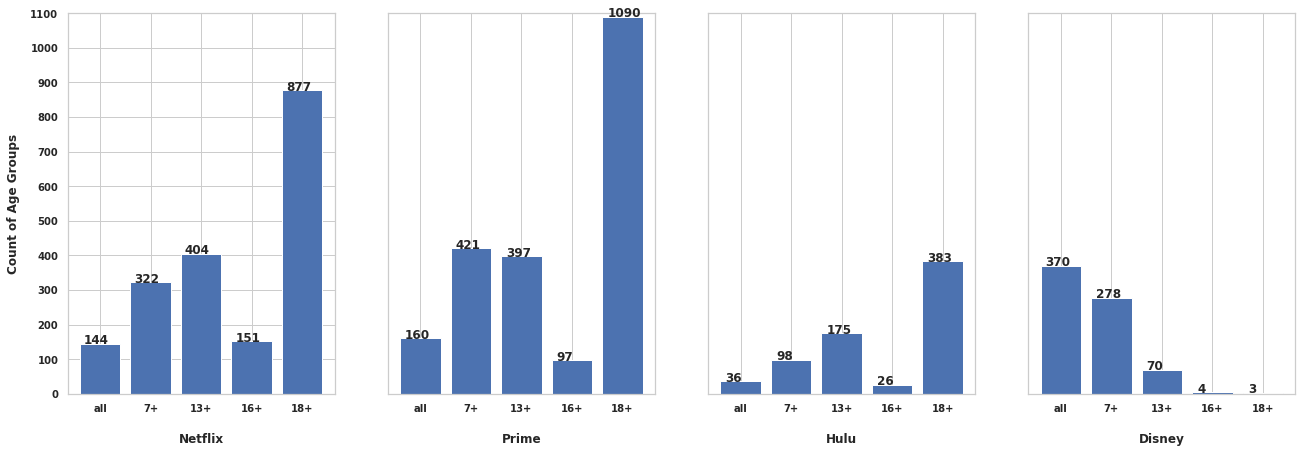

In [28]:
#Set style
sb.set(style="whitegrid")

#Groups
grp_index = plt_df['Age_Group'].to_list()

#Set subplot configuration
fig, ax = plt.subplots(1, 4)

#Set fonts
title_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 18}
sub_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 12}

#Plot Netflix data
y1 = plt_df['Netflix_Counts'].to_list()
ax[0].bar(grp_index,y1)
ax[0].set_ylim(bottom=0, top=1100)
ax[0].set_title('Netflix',sub_font,loc='center',pad=8,y=-0.15)
ax[0].axes.set_ylabel('Count of Age Groups',labelpad=10,fontdict=sub_font)
ax[0].tick_params(axis='x',labelsize= 10)
ax[0].tick_params(axis='y',labelsize= 10)
ax[0].set_yticks(np.arange(0, 1200, 100))
#Set text labels
xlocs=[i+1 for i in range(0,5)]
for i, v in enumerate(y1):
   ax[0].text(xlocs[i] - 1.32, v + 0.2, str(v))

#Plot Prime data   
y2 = plt_df['Prime_Counts'].to_list()
ax[1].bar(grp_index,y2)
ax[1].set_ylim(bottom=0, top=1100)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Prime',sub_font,loc='center',pad=8,y=-0.15)
ax[1].tick_params(axis='x',labelsize= 10)
#Set text labels
for i, v in enumerate(y2):
    ax[1].text(xlocs[i] - 1.3, v - 0.1, str(v))

#Plot Hulu data  
y3 = plt_df['Hulu_Counts'].to_list()
ax[2].bar(grp_index,y3)
ax[2].set_ylim(bottom=0, top=1100)
ax[2].axes.yaxis.set_visible(False)
ax[2].set_title('Hulu',sub_font,loc='center',pad=8,y=-0.15)
ax[2].tick_params(axis='x',labelsize= 10)
#Set text labels
for i, v in enumerate(y3):
    ax[2].text(xlocs[i] - 1.3, v + 0.01, str(v))

#Plot Disney data      
y4 = plt_df['Disney_Counts'].to_list()
ax[3].bar(grp_index,y4)
ax[3].set_ylim(bottom=0, top=1100)
ax[3].axes.yaxis.set_visible(False)
ax[3].set_title('Disney',sub_font,loc='center',pad=8,y=-0.15)
ax[3].tick_params(axis='x',labelsize= 10)
#Set text labels
for i, v in enumerate(y4):
    ax[3].text(xlocs[i]-1.3, v + 0.01, str(v))

fig = plt.gcf() 
fig.set_size_inches(22,7)

plt.show()

From a quick glance at this data, it is clear that most movies streamed on Netflix, Prime and Hulu target the "18+" age group, whereas in Disney+ the main target age groups are "all" or "7+", being that "all" should encompass children under the age of 7. To better understand the importance of these age groups, the same graph was plotted for the percentage of each age group.

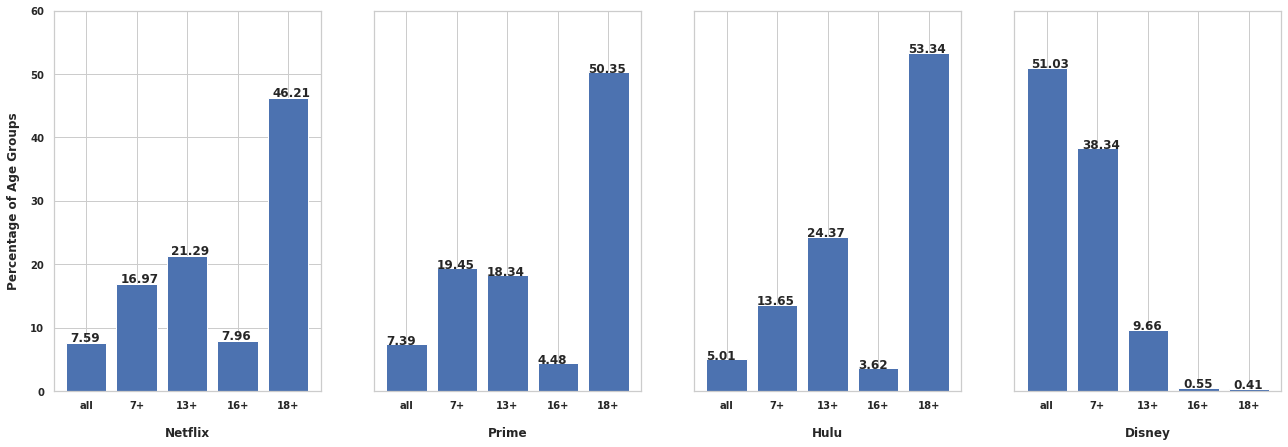

In [29]:
#Set style
sb.set(style="whitegrid")

#Set subplot configuration
fig, ax = plt.subplots(1, 4)

#Set fonts
title_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 18}
sub_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 12}

#Convert data to percentage
s1 = plt_df['Netflix_Counts'].sum()
p1 = plt_df['Netflix_Counts']*100/s1
y1 = round(p1,2).to_list()

#Plot Netflix data
ax[0].bar(grp_index,y1)
ax[0].set_ylim(bottom=0, top=60)
ax[0].set_title('Netflix',sub_font,loc='center',pad=0,y=-0.12)
ax[0].axes.set_ylabel('Percentage of Age Groups',labelpad=10,fontdict=sub_font)
ax[0].tick_params(axis='x',labelsize= 10)
ax[0].tick_params(axis='y',labelsize= 10)
ax[0].set_yticks(np.arange(0, 70, 10))
#Set text labels
xlocs=[i+1 for i in range(0,5)]
for i, v in enumerate(y1):
   ax[0].text(xlocs[i] - 1.32, v + 0.2, str(v))

#Convert data to percentage
s2 = plt_df['Prime_Counts'].sum()
p2 = plt_df['Prime_Counts']*100/s2
y2 = round(p2,2).to_list()
#Plot Prime data
ax[1].bar(grp_index,y2)
ax[1].set_ylim(bottom=0, top=60)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_title('Prime',sub_font,loc='center',pad=0,y=-0.12)
ax[1].tick_params(axis='x',labelsize= 10)
#Set text labels
for i, v in enumerate(y2):
    ax[1].text(xlocs[i] - 1.4, v - 0.1, str(v))
    
#Convert data to percentage
s3 = plt_df['Hulu_Counts'].sum()
p3 = plt_df['Hulu_Counts']*100/s3
y3 = round(p3,2).to_list()
#Plot Hulu data
ax[2].bar(grp_index,y3)
ax[2].set_ylim(bottom=0, top=60)
ax[2].axes.yaxis.set_visible(False)
ax[2].set_title('Hulu',sub_font,loc='center',pad=0,y=-0.12)
ax[2].tick_params(axis='x',labelsize= 10)
#Set text labels
for i, v in enumerate(y3):
    ax[2].text(xlocs[i] - 1.4, v + 0.01, str(v))

#Convert data to percentage
s4 = plt_df['Disney_Counts'].sum()
p4 = plt_df['Disney_Counts']*100/s4
y4 = round(p4,2).to_list()
#Plot Disney data 
ax[3].bar(grp_index,y4)
ax[3].set_ylim(bottom=0, top=60)
ax[3].axes.yaxis.set_visible(False)
ax[3].set_title('Disney',sub_font,loc='center',pad=0,y=-0.12)
ax[3].tick_params(axis='x',labelsize= 10)
#Set text labels
for i, v in enumerate(y4):
    ax[3].text(xlocs[i]-1.3, v + 0.01, str(v))

fig = plt.gcf() 
fig.set_size_inches(22,7)

plt.show()

We can now observe that the main target age group in each platform comprises approximately 46-53% of all movies streamed, being that the highest percentage belongs to Hulu and the lowest to Netflix. We also find that none of the streaming platforms seem to have a high amount of movies targeting the "16+" age group, most likely since it is too specific to be targeted by most movies in general. 

### Release Year

In order to observe the distribution of older movies vs recent movies in each streaming platform, a grouped barplot similar to the previous was created.

In [30]:
#Get counts for every value in the "Year" column, for each streaming platform
netflix_year = netflix_data['Year'].value_counts().rename_axis('Year').reset_index(name='Netflix_Counts')
prime_year = prime_data['Year'].value_counts().rename_axis('Year').reset_index(name='Prime_Counts')
hulu_year = hulu_data['Year'].value_counts().rename_axis('Year').reset_index(name='Hulu_Counts')
disney_year = disney_data['Year'].value_counts().rename_axis('Year').reset_index(name='Disney_Counts')

#Remove missing values
netflix_year = netflix_year[netflix_year.Year != '']
prime_year = prime_year[prime_year.Year != '']
hulu_year = hulu_year[hulu_year.Year != '']
disney_year = disney_year[disney_year.Year != '']

#Join all value counts in one dataframe
plt_df = pd.merge(netflix_year, prime_year, on='Year')
plt_df = pd.merge(plt_df,hulu_year,on='Year')
plt_df = pd.merge(plt_df,disney_year,on='Year')

plt_df.head()

,Year,Netflix_Counts,Prime_Counts,Hulu_Counts,Disney_Counts
0,2019,573,256,156,50
1,2018,540,285,108,34
2,2020,478,204,116,71
3,2017,449,285,91,28
4,2016,313,254,66,27


To change up the visualization a bit, the order of subplots was changed to a 2x2 grid style.

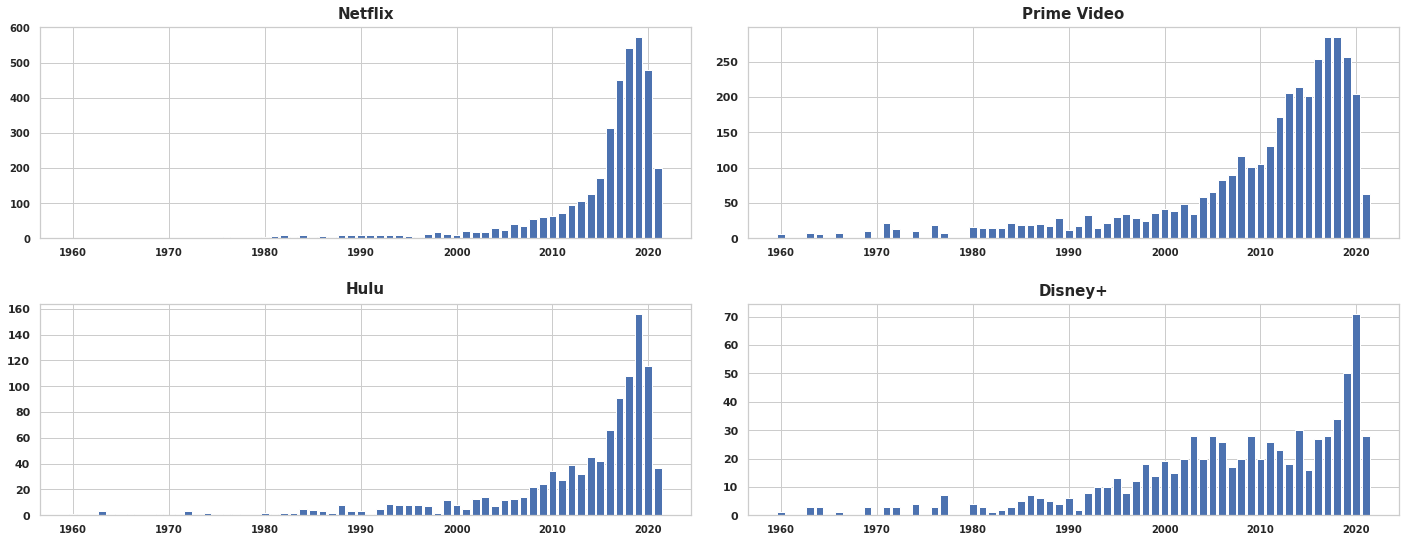

In [31]:
#Set style
sb.set(style="whitegrid")

#Groups
grp_index = plt_df['Year'].to_list()

#Set subplot configuration
fig, ax = plt.subplots(2, 2)

#Set fonts
font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 15}

#Plot Netflix data
y1 = plt_df['Netflix_Counts'].to_list()
ax[0,0].bar(grp_index,y1)
ax[0,0].set_title('Netflix',font,loc='center',pad=8,y=1.0)
ax[0,0].tick_params(axis='x',labelsize= 10)
ax[0,0].tick_params(axis='y',labelsize= 10)


#Plot Prime data    
y2 = plt_df['Prime_Counts'].to_list()
ax[0,1].bar(grp_index,y2)
ax[0,1].set_title('Prime Video',font,loc='center',pad=8,y=1.0)
ax[0,1].tick_params(axis='x',labelsize= 10)

#Plot Hulu data  
y3 = plt_df['Hulu_Counts'].to_list()
ax[1,0].bar(grp_index,y3)
ax[1,0].set_title('Hulu',font,loc='center',pad=10,y=1.0)
ax[1,0].tick_params(axis='x',labelsize= 10)

#Plot Disney data     
y4 = plt_df['Disney_Counts'].to_list()
ax[1,1].bar(grp_index,y4)
ax[1,1].set_title('Disney+',font,loc='center',pad=8,y=1.0)
ax[1,1].tick_params(axis='x',labelsize= 10)

fig = plt.gcf() 
fig.set_size_inches(20,8)
fig.tight_layout(pad=2.0)

plt.show()

Excluding the current year of 2021 from this analysis, since there are many more movies yet to be included in this dataset, we can take a few conclusions.

In Netflix, Prime Video and Hulu, recent movies are streamed often more than others, since generally, the older the movie is, the less likely it is to be streamed. However, the amount of movies from 2019 seems to always surpass that of 2020, which may possibly be due to a decrease in the amount of movies produced as a result of the COVID pandemic.

In the case of Disney+, movie counts from 2004-2017 fluctuate around similar values (range between 20 and 30 movies), suddenly spiking for 2019 movies and rising even higher for 2020 movies. This is an interesting fact, since we would expect movies produced in 2020 to have lower counts, due to the effects of COVID. As such, this indicates that despite there having been less movies produced in 2020, these are still streamed most often, as some movies from the previous year are sidelined. As we can see, other streaming platforms are not as quick to sideline movies from 2019 or 2018. We can also speculate that due to the targeted age groups being small children and teens, who have more free time to watch movies as opposed to adults and therefore quickly become bored of repetition, new movies are prioritized to keep the audience interested.

### Country of Production

To obtain more insight on which country(or countries) most often serve as the setting for a movie's production, a geographic plot commonly known as a chrolopleth map was created to show how many movies are produced in each country, for each streaming platform. As usual, we start by creating a new dataframe comprised of the necessary data.

In [32]:
# Int Vars
col = 15 # Since the one-hot-encoded columns begin in column 16 and onward
count = 0 # Aux int

# List of all columns in the encoded dataframe
list_of_cols = df_encoded.columns

#Country list
c = [] 
# List of genre counts for each of the 4 platforms
c_count = [[],[],[],[]] 
c_ratings_imdb = []
c_ratings_rt = []

#Groups
plat_index = [netflix_data, hulu_data, prime_data, disney_data] 
 
# For each one-hot-encoded genre column, count the total of ocurrences and append it to our c_count list 
# To later analyse the average IMDb and Rotten Tomatoes review scores in each country, 2 lists were added containing these values (c_ratings_imdb and c_ratings_rt)
while count < len(c_count):
    col = 15
    while col < len(list_of_cols): 
        if 'Country' in list_of_cols[col][0:7]:
            c_count[count].append(plat_index[count][list_of_cols[col]].sum())
            if count == 0:
                c.append(list_of_cols[col])
                c_ratings_imdb.append(df_encoded.loc[df_encoded[list_of_cols[col]]==1]['IMDb'].mean())
                c_ratings_rt.append(df_encoded.loc[df_encoded[list_of_cols[col]]==1]['Rotten Tomatoes'].mean())
        col = col + 1
    count = count + 1 

# Create a dataframe from each list of counts, for every streaming platform    
country_count = pd.DataFrame(
    {'Country': c,
     'Count of Netflix Movies': c_count[0],
     'Count of Hulu Movies': c_count[1],
     'Count of Prime Movies': c_count[2],
     'Count of Disney Movies': c_count[3],
     'Average IMDb Score':c_ratings_imdb,
     'Average Rotten Tomatoes Score': c_ratings_rt
    })

In [33]:
country_count.head()

,Country,Count of Netflix Movies,Count of Hulu Movies,Count of Prime Movies,Count of Disney Movies,Average IMDb Score,Average Rotten Tomatoes Score
0,Country_United States,1671.0,805.0,2758.0,856.0,6.063179,5.559154
1,Country_India,578.0,9.0,321.0,6.0,6.271000,5.164111
2,Country_United Kingdom,305.0,153.0,459.0,89.0,6.252604,5.862500
3,Country_Australia,39.0,41.0,93.0,27.0,6.058730,5.776720
4,Country_Kenya,4.0,0.0,2.0,0.0,7.116667,5.433333


We now add a column containing the correct country names, without the "Country" prefix.

In [34]:
country_count['Country_Name'] = country_count['Country'].str[8:]

In [35]:
country_count.head()

,Country,Count of Netflix Movies,Count of Hulu Movies,Count of Prime Movies,Count of Disney Movies,Average IMDb Score,Average Rotten Tomatoes Score,Country_Name
0,Country_United States,1671.0,805.0,2758.0,856.0,6.063179,5.559154,United States
1,Country_India,578.0,9.0,321.0,6.0,6.271000,5.164111,India
2,Country_United Kingdom,305.0,153.0,459.0,89.0,6.252604,5.862500,United Kingdom
3,Country_Australia,39.0,41.0,93.0,27.0,6.058730,5.776720,Australia
4,Country_Kenya,4.0,0.0,2.0,0.0,7.116667,5.433333,Kenya


In [36]:
#Number of countries present in our dataset
len(country_count['Country'])

130

We can make use of the open source Geopandas project for plotting data on a world map, being that this project contains the necessary geospatial data to describe the geometry of each country, as well as its name, continent and population estimate. To import this project, we must first install the following dependency:

In [37]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [38]:
import geopandas as gpd

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [39]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [40]:
world.head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


In order to verify if our dataframe can be merged successfully with the "world" dataframe, we perform a left join between the two and check if all entries remain. 

In [41]:
#left join both dataframes
country_df = country_count.merge(world,left_on='Country_Name',right_on='name',how='left')

In [42]:
#Define the missing entries dataframe
miss = country_df[country_df['name'].isna()]

In [43]:
#Number of entries that did not match (27)
miss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 124
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Country                        27 non-null     object  
 1   Count of Netflix Movies        27 non-null     float64 
 2   Count of Hulu Movies           27 non-null     float64 
 3   Count of Prime Movies          27 non-null     float64 
 4   Count of Disney Movies         27 non-null     float64 
 5   Average IMDb Score             27 non-null     float64 
 6   Average Rotten Tomatoes Score  27 non-null     float64 
 7   Country_Name                   27 non-null     object  
 8   pop_est                        0 non-null      float64 
 9   continent                      0 non-null      object  
 10  name                           0 non-null      object  
 11  iso_a3                         0 non-null      object  
 12  gdp_md_est                     0 non-

In [44]:
#We print the country names of unmatched entries
print(miss['Country_Name'].unique())

['United States' 'Congo - Brazzaville' 'Hong Kong SAR China' 'Malta'
 'Bermuda' 'Singapore' 'Palestinian Territories' 'Bosnia & Herzegovina'
 'Serbia and Montenegro' 'West Germany' 'Cayman Islands' 'Réunion'
 'Mauritius' 'Soviet Union' 'Liechtenstein' 'Aruba' 'Korea'
 'Republic of North Macedonia' 'Côte d’Ivoire'
 'Federal Republic of Yugoslavia' 'Monaco' 'Yugoslavia' 'Guam'
 'Isle of Man' 'Congo - Kinshasa' 'Trinidad & Tobago' 'East Germany']


In [45]:
#The designation of each country in the "world" dataframe was checked
world.loc[world['name'].str.contains('Congo') == 1].head() 

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
67,4954674,Africa,Congo,COG,30270.0,"POLYGON ((18.45307 3.50439, 18.39379 2.90044, ..."


In [46]:
#The designation of each country in the original dataset was checked and compared
country_count.loc[country_count['Country_Name'].str.contains('Congo') == 1].head() 

,Country,Count of Netflix Movies,Count of Hulu Movies,Count of Prime Movies,Count of Disney Movies,Average IMDb Score,Average Rotten Tomatoes Score,Country_Name
8,Country_Congo - Brazzaville,1.0,0.0,0.0,0.0,8.2,9.0,Congo - Brazzaville
117,Country_Congo - Kinshasa,0.0,0.0,1.0,0.0,6.5,4.8,Congo - Kinshasa


By taking a look at this result and the previous print, we see that the Democratic Republic of Congo has diferent representations in our movies dataset,when compared to the geopandas dataframe. Other special cases were found in our dataset, such as the states of East and West Germany, which were reunified with the Federal Republic of Germany over 30 years ago, which are therefore outdated and should now simply be listed as "Germany". These inconsistencies were manually observed and fixed via the "replace" method. Small countries or island nations such as "Liechtenstein" or "Malta", which were not yet included in the geopandas open source project, were disregarded in this analysis.

In [47]:
#All inconsistent designations are rectified in the country_count dataframe
country_count = country_count.replace({'Country_Name':{'United States':'United States of America', 
                  'Congo - Brazzaville':'Dem. Rep. Congo',
                  'Congo - Kinshasa':'Dem. Rep. Congo',                                    
                  'Palestinian Territories':'Palestine',
                  'Bosnia & Herzegovina':'Bosnia and Herz.',
                  'Serbia and Montenegro':'Serbia',
                  'Hong Kong SAR China':'China',                                  
                  'Soviet Union':'Russia',
                  'Aruba':'Netherlands',
                  'Korea':'South Korea',
                  'Republic of North Macedonia':'Macedonia',
                  "Côte d’Ivoire":"Côte d'Ivoire",
                  'Federal Republic of Yugoslavia':'Serbia',
                  'Yugoslavia':'Serbia',
                  'Congo - Kinshasa':'Dem. Rep. Congo',
                  'Trinidad & Tobago':'Trinidad and Tobago',
                  'West Germany':'Germany',
                  'East Germany':'Germany'
                 }})

In [48]:
#Inner join both dataframes
country_df = country_count.merge(world,left_on='Country_Name',right_on='name')

In [49]:
#Amount of entries after manual correction
len(country_df)

120

The two dataframes are now inner joined into one dataframe, containing 120 entries out of the original 130. These remaining 10 pertain to countries not yet featured in the geopandas dataset. To plot our chrolopleth maps, we require only the following dependency:

In [50]:
pip install mapclassify

Note: you may need to restart the kernel to use updated packages.


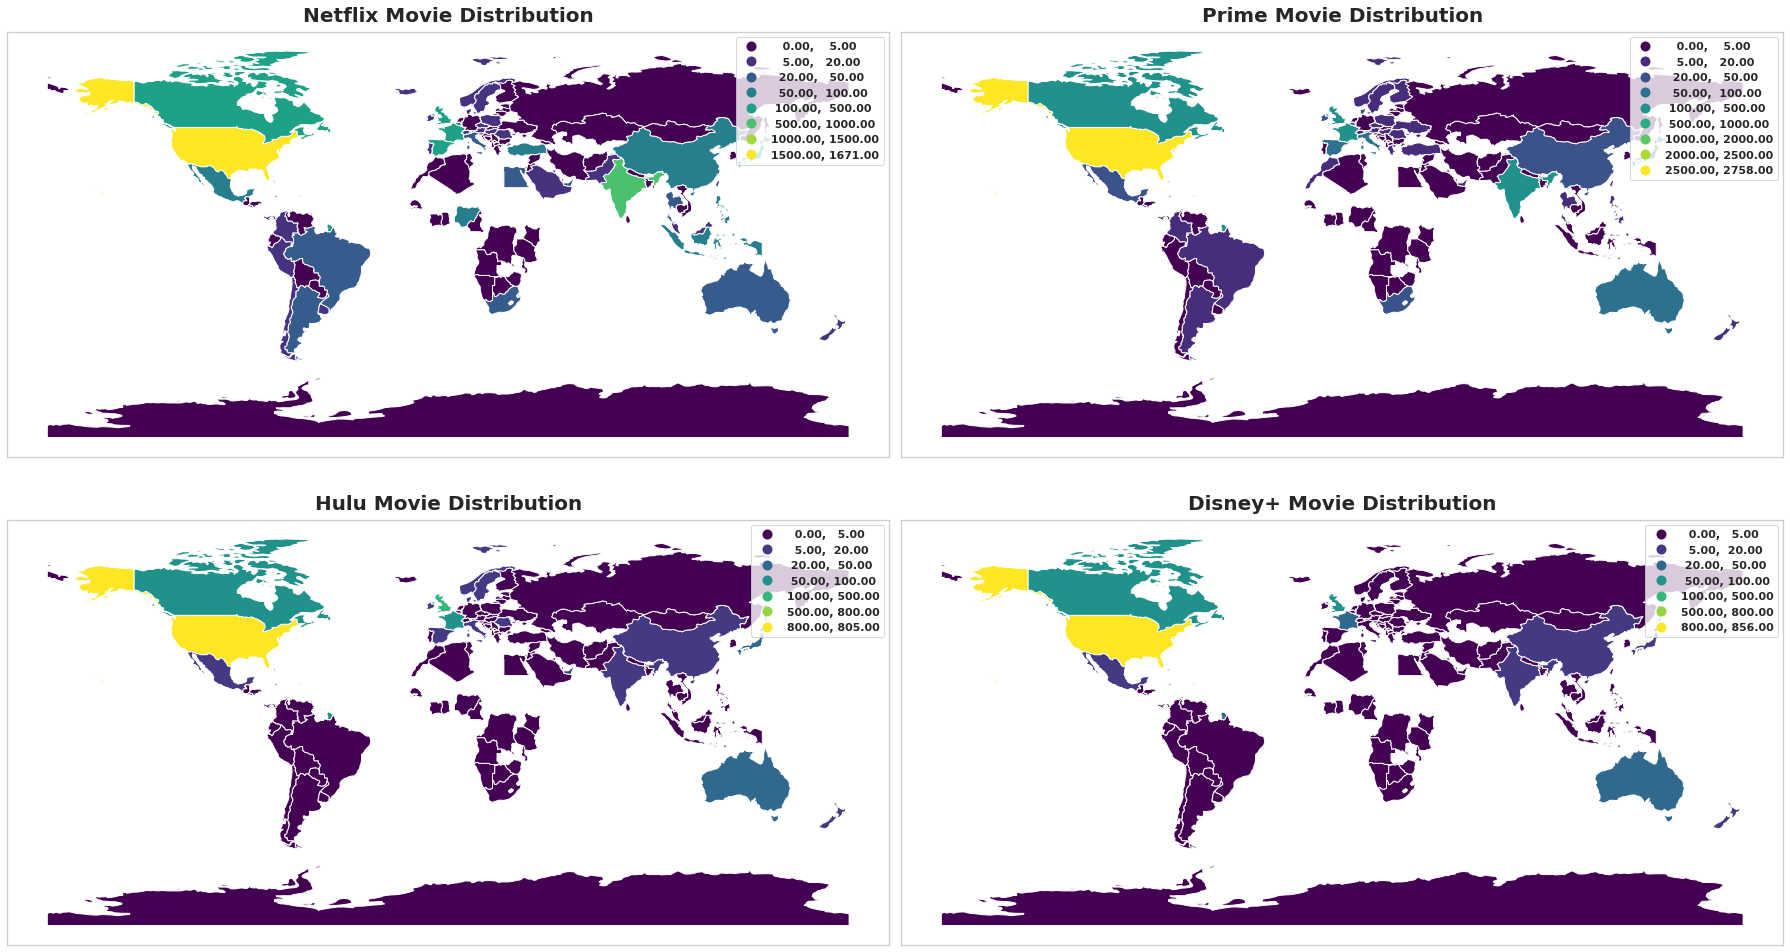

In [51]:
#Make a geopandas dataframe from the joint dataframe
gdf_world = gpd.GeoDataFrame(country_df)

#Title font
font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 20}

#Set 2x2 grid configuration, made up of 4 subplots
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25, 14))

plt_df = gdf_world

bins1 = [5,20,50,100,500,1000,2000,2500]
bins2 = [5,20,50,100,500,1000,1500]
bins3 = [5,20,50,100,500,800]

colormap = 'viridis'

#Netflix chrolopleth map
ax1 = plt_df.plot(ax=ax1, column = plt_df['Count of Netflix Movies'],scheme='userdefined',legend=True,classification_kwds={'bins': bins2},cmap=colormap)
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax1.set_title('Netflix Movie Distribution',font,loc='center',pad=10,y=1.0)
#Prime Video chrolopleth map
ax2 = plt_df.plot(ax=ax2,column = plt_df['Count of Prime Movies'],legend=True,scheme='userdefined',classification_kwds={'bins': bins1},cmap=colormap)
ax2.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.set_title('Prime Movie Distribution',font,loc='center',pad=10,y=1.0)
#Hulu chrolopleth map
ax3 = plt_df.plot(ax=ax3,column = plt_df['Count of Hulu Movies'],legend=True,scheme='userdefined',classification_kwds={'bins': bins3},cmap=colormap)
ax3.axes.yaxis.set_visible(False)
ax3.axes.xaxis.set_visible(False)
ax3.set_title('Hulu Movie Distribution',font,loc='center',pad=10,y=1.0)
#Disney+ chrolopleth map
ax4 = plt_df.plot(ax=ax4,column = plt_df['Count of Disney Movies'],legend=True,scheme='userdefined',classification_kwds={'bins': bins3},cmap=colormap)
ax4.axes.yaxis.set_visible(False)
ax4.axes.xaxis.set_visible(False)
ax4.set_title('Disney+ Movie Distribution',font,loc='center',pad=10,y=1.0)

fig.tight_layout(pad=1.0)

From this visualization, we observe that in every streaming application,the highest movie count comes from the United States, which makes sense since we are speaking of American streaming platforms, despite their global reach.
We can also note that Canada, France, Australia, French Guiana and the United Kingdom always exhibit high movie counts in every platform. As opposed to other streaming platforms, Netflix streams a significant amount of movies that take place in Turkey (50-100),Nigeria (50-100), Egypt (20-50), Malaysia (50-100), Indonesia (50-100) and Papua New Guinea (50-100). As such, we find that although Prime Video streams more movies than Netflix, the latter seems to provide slightly more diversity in terms of its movies' geographical setting, which may attract a certain audience that other platforms do not.

### Review Score

Review scores are an important factor in choosing which movies to stream since, generally, user ratings will be proportional to official review scores. However, official review scores may differ significantly depending on the chosen source, as is evident in the case of IMDb and Rotten Tomatoes - two of the largest authorities for trusted measurement of a movie's quality. In order to analyse the distribution of both IMDb and Rotten Tomatoes (RT) review scores of movies across each streaming platform, a paired boxplot was created.

In [52]:
#We first create new dataframes excluding missing values,for each platform.
netflix_data_nonan = netflix_data[(netflix_data['IMDb'] != 0) & (netflix_data['Rotten Tomatoes'] != 0)]
hulu_data_nonan = hulu_data[(hulu_data['IMDb'] != 0) & (hulu_data['Rotten Tomatoes'] != 0)]
prime_data_nonan = prime_data[(prime_data['IMDb'] != 0) & (prime_data['Rotten Tomatoes'] != 0)]
disney_data_nonan = disney_data[(disney_data['IMDb'] != 0) & (disney_data['Rotten Tomatoes'] != 0)]

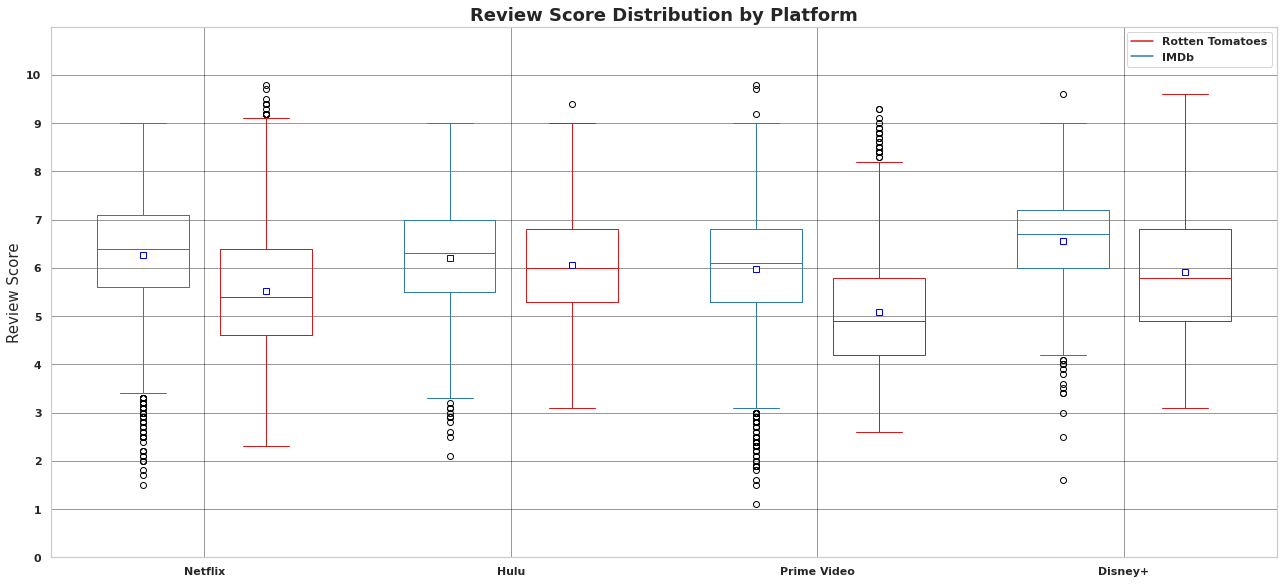

In [53]:
#Set plot style
sb.set_style("whitegrid")

#Set fonts
axis_font = {'family': 'sans-serif',
        'fontweight' : 'normal',
        'fontsize'   : 15}
title_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 18}
#Data
imdb_data = [netflix_data_nonan['IMDb'].to_list(), hulu_data_nonan['IMDb'].to_list(), prime_data_nonan['IMDb'].to_list(),disney_data_nonan['IMDb'].to_list()]
RT_data = [netflix_data_nonan['Rotten Tomatoes'].to_list(), hulu_data_nonan['Rotten Tomatoes'].to_list(), prime_data_nonan['Rotten Tomatoes'].to_list(), disney_data_nonan['Rotten Tomatoes'].to_list()]

#Groups
platform = ['Netflix','Hulu','Prime Video','Disney+']

#We create a function that colors in all boxplot elements
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

#Set plot size
plt.figure(figsize=(18,8))
    
#IMDb boxplot
bpb = plt.boxplot(imdb_data, positions=np.array(range(len(imdb_data)))*2.0 -0.4, widths = 0.6, showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
#RT boxplot
bpr = plt.boxplot(RT_data, positions=np.array(range(len(RT_data)))*2.0 + 0.4, widths=0.6, showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})

#Set boxplot color
set_box_color(bpb, '#2C7BB6') 
set_box_color(bpr, '#D7191C')

# Draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Rotten Tomatoes')
plt.plot([], c='#2C7BB6', label='IMDb')
plt.legend(loc=1)

# Other plot configurations
plt.ylabel('Review Score',axis_font)
plt.xticks(range(0, len(platform) * 2, 2), platform)
plt.xlim(-1, 7)
plt.ylim(0, 11)
plt.yticks(np.arange(0, 11, 1))
plt.tight_layout()
plt.title('Review Score Distribution by Platform',fontdict=title_font)
plt.grid(alpha=0.4,color='black')

plt.show()

At a first glance at the range of values and mean points, it is clear that scores given by IMDb are generally higher than those given by Rotten Tomatoes. By examining the median lines and mean points, we can observe that the distribution of scores given by IMDb is mostly negatively skewed, whereas the distribution of scores given by Rotten Tomatoes is mostly positively skewed. Furthermore, there are more outliers in IMDb scores than in Rotten Tomatoes scores, being that the former are generally negative outliers and the later mostly positive outliers. IDMb outliers can also reach values below Rotten Tomatoes' lower quartile, similarly to how Rotten Tomatoes outliers can reach values above IMDb's upper quartile. Although similar in value, Disney+ shows the highest mean IMDb review score among streaming platforms (around 6.5) and Hulu shows the highest mean Rotten Tomatoes review score (6.0). Netflix and Prime Video also exhibit more negative outliers than Hulu and Disney+, indicating a larger archive of lower rated movies (so called "bad" movies), which are likely more popular among older audiences (16+), which constitute the main target audience for Netflix and Prime Video.

To find out how these review scores are distributed throughout different movie genres, a lineplot comparison chart was constructed for both IDMb and Rotten Tomatoes.

In [54]:
#Genre list
g = [] 
# Aux int
count=0 

# List of average IMDb review scores for each genre in each of the 4 platforms
g_avg_imdb = [[],[],[],[]] 
# List of average Rotten Tomatoes review scores for each genre in each of the 4 platforms
g_avg_rt = [[],[],[],[]]

list_of_cols = df_encoded.columns

#List of genre columns, sorted alphabetically.
sorted_cols = sorted([gen for gen in list_of_cols if 'Genres_' in gen]) 

#Data
plat_index = [netflix_data_nonan, hulu_data_nonan, prime_data_nonan, disney_data_nonan] 

#Get average review score for each genre, for each streaming platform
while count < len(g_avg_imdb):
    col = 0
    while col < len(sorted_cols): 
        g_filter = plat_index[count].loc[plat_index[count][sorted_cols[col]]==1]
        if g_filter['IMDb'].shape[0]>=1:
            g_avg_imdb[count].append(round(plat_index[count].loc[plat_index[count][sorted_cols[col]]==1]['IMDb'].mean(),2))
            g_avg_rt[count].append(round(plat_index[count].loc[plat_index[count][sorted_cols[col]]==1]['Rotten Tomatoes'].mean(),2))
        else:
            g_avg_imdb[count].append(0)
            g_avg_rt[count].append(0)
        if count == 0:
            g.append(sorted_cols[col][7:])
        col = col + 1
    count = count + 1 

#Insert data into new dataframe
gscore_imdb = pd.DataFrame(
    {'Genre': g,
     'Netflix Avg Score': g_avg_imdb[0],
     'Prime Avg Score': g_avg_imdb[1],
     'Hulu Avg Score': g_avg_imdb[2],
     'Disney Avg Score': g_avg_imdb[3],
    })
gscore_rt = pd.DataFrame(
    {'Genre': g,
     'Netflix Avg Score': g_avg_rt[0],
     'Prime Avg Score': g_avg_rt[1],
     'Hulu Avg Score': g_avg_rt[2],
     'Disney Avg Score': g_avg_rt[3],
    })
      

In [55]:
gscore_imdb.head()

,Genre,Netflix Avg Score,Prime Avg Score,Hulu Avg Score,Disney Avg Score
0,Action,6.01,6.06,5.50,6.61
1,Adventure,6.03,6.30,5.63,6.58
2,Animation,6.33,6.30,5.81,6.81
3,Biography,6.85,6.87,6.81,7.21
4,Comedy,6.16,6.08,5.94,6.45


In [56]:
gscore_rt.head()

,Genre,Netflix Avg Score,Prime Avg Score,Hulu Avg Score,Disney Avg Score
0,Action,5.75,6.41,5.15,6.88
1,Adventure,5.79,6.44,5.18,6.61
2,Animation,5.48,5.99,4.93,6.17
3,Biography,6.26,6.43,5.63,6.68
4,Comedy,5.40,6.14,5.14,6.07


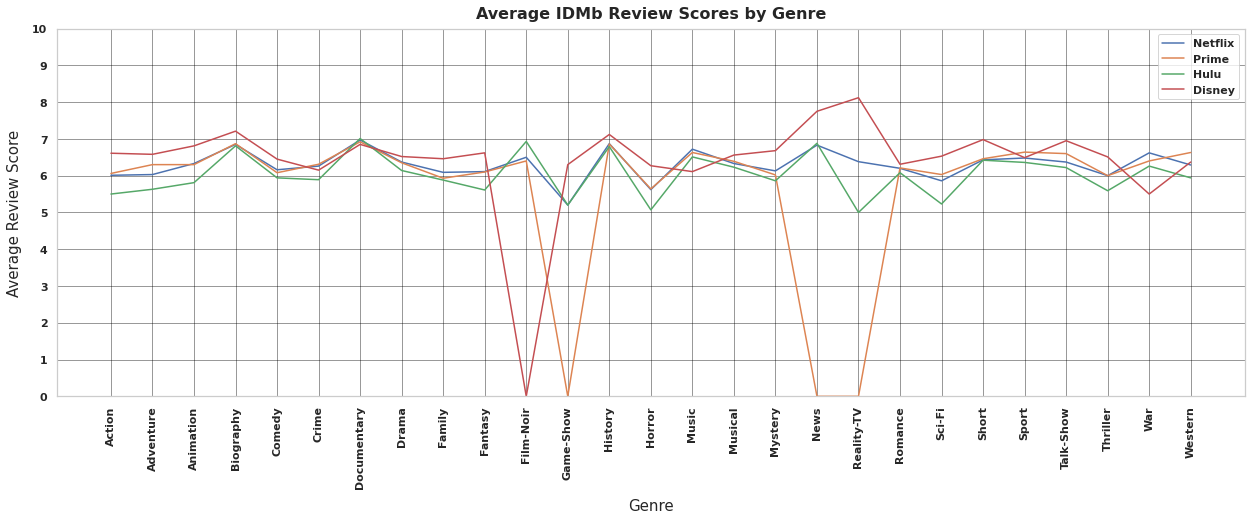

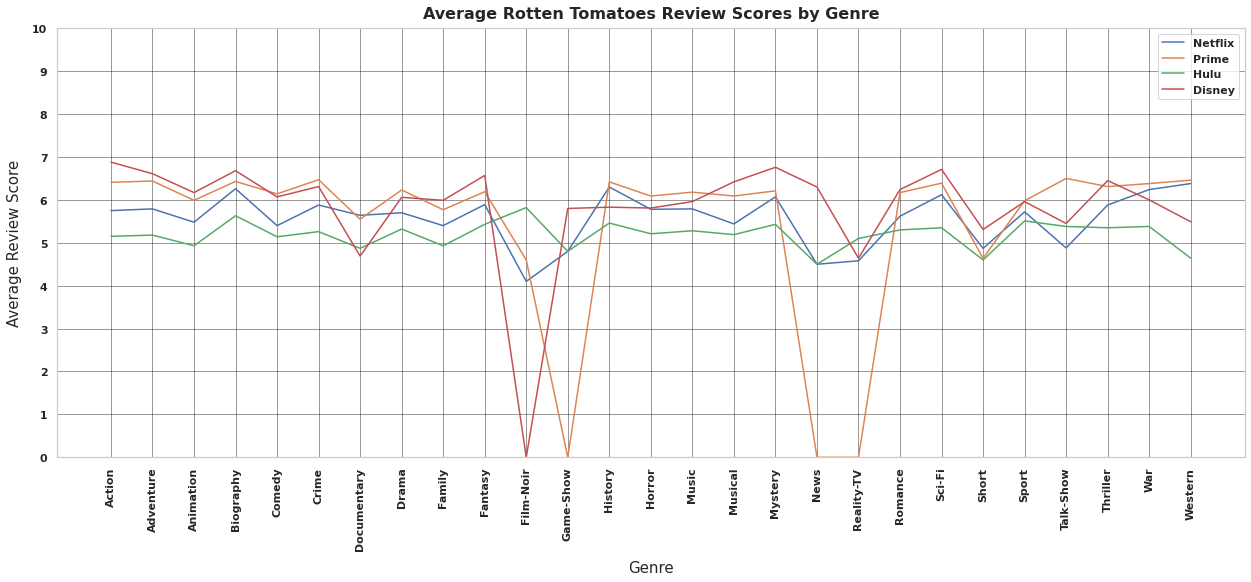

In [57]:
#Set style
sb.set(style="whitegrid")

#Title font
title_font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 16}
#Sub font
sub_font = {'family': 'sans-serif',
        'fontweight' : 'normal',
        'fontsize'   : 15}

#Plot for average IMDb scores by genre
plot1 = plt.figure(1)
#Plot settings
sb.lineplot(x='Genre',y='value',hue = 'variable',data=pd.melt(gscore_imdb, ['Genre']))
plt.xticks(rotation = 90)
plt.ylabel('Average Review Score',fontdict=sub_font,labelpad = 10.0)
plt.xlabel('Genre',fontdict=sub_font,labelpad = 10.0)
plt.legend(loc='upper right')
plt.ylim((0,10))
plt.title('Average IDMb Review Scores by Genre',title_font,loc='center',pad=10,y=1.0)
L=plt.legend()
L.get_texts()[0].set_text('Netflix')
L.get_texts()[1].set_text('Prime')
L.get_texts()[2].set_text('Hulu')
L.get_texts()[3].set_text('Disney')
plt.grid(alpha=0.4,color='black')
plt.yticks(np.arange(0, 11, 1))

fig = plt.gcf() 
fig.tight_layout()
fig.set_size_inches(20,12)

#Plot for average Rotten Tomatoes scores by genre
plot2 = plt.figure(2)
#Plot settings
sb.lineplot(x='Genre',y='value',hue = 'variable',data=pd.melt(gscore_rt, ['Genre']))
plt.xticks(rotation = 90)
plt.ylabel('Average Review Score',fontdict=sub_font,labelpad = 10.0)
plt.xlabel('Genre',fontdict=sub_font,labelpad = 10.0)
plt.legend(loc='upper right')
plt.ylim((0,10))
plt.title('Average Rotten Tomatoes Review Scores by Genre',title_font,loc='center',pad=10,y=1.0)
L=plt.legend()
L.get_texts()[0].set_text('Netflix')
L.get_texts()[1].set_text('Prime')
L.get_texts()[2].set_text('Hulu')
L.get_texts()[3].set_text('Disney')
plt.grid(alpha=0.4,color='black')
plt.yticks(np.arange(0, 11, 1))

fig = plt.gcf() 
fig.tight_layout()
fig.set_size_inches(20,14)

plt.show()

Finally, a look was taken at the review score distribution among different countries, by means of a chloropleth map for each source (IMDb and Rotten Tomatoes).

In [58]:
gdf_world = gpd.GeoDataFrame(country_df)
plt_df = gdf_world

In [59]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

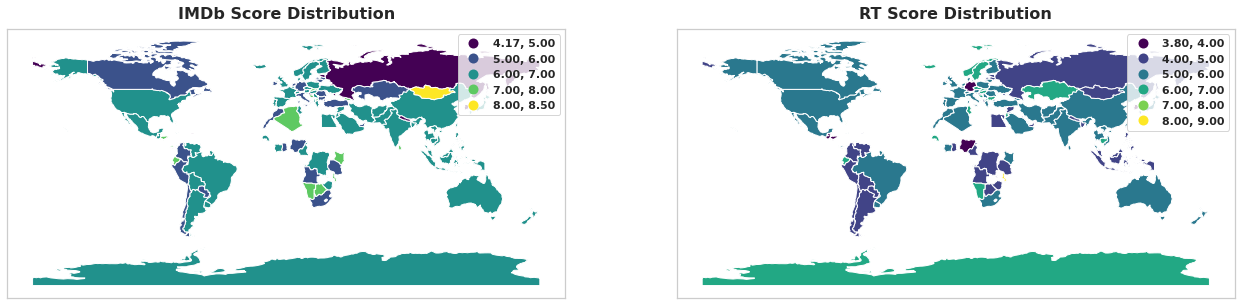

In [60]:
#Title font
font = {'family': 'sans-serif',
        'fontweight' : 'bold',
        'fontsize'   : 16}

#Set subplot configuration
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

bins = [5,6,7,8]
bins1 = [4,5,6,7,8]
colormap = 'viridis'

#IMDb score map plot
ax1 = plt_df.plot(ax=ax1, column = plt_df['Average IMDb Score'],legend=True,scheme='userdefined',classification_kwds={'bins': bins},cmap=colormap)
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax1.set_title('IMDb Score Distribution',font,loc='center',pad=10,y=1.0)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#RT score map plot
ax2 = plt_df.plot(ax=ax2,column = plt_df['Average Rotten Tomatoes Score'],legend=True,scheme='userdefined',classification_kwds={'bins': bins1},cmap=colormap)
ax2.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.set_title('RT Score Distribution',font,loc='center',pad=10,y=1.0)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

fig.tight_layout(pad=0)

Since it is sometimes dificult to visualize these maps in detail, it was found that, when not using a more suitable BI solution, the maps should be visualised separately instead of using subplots.

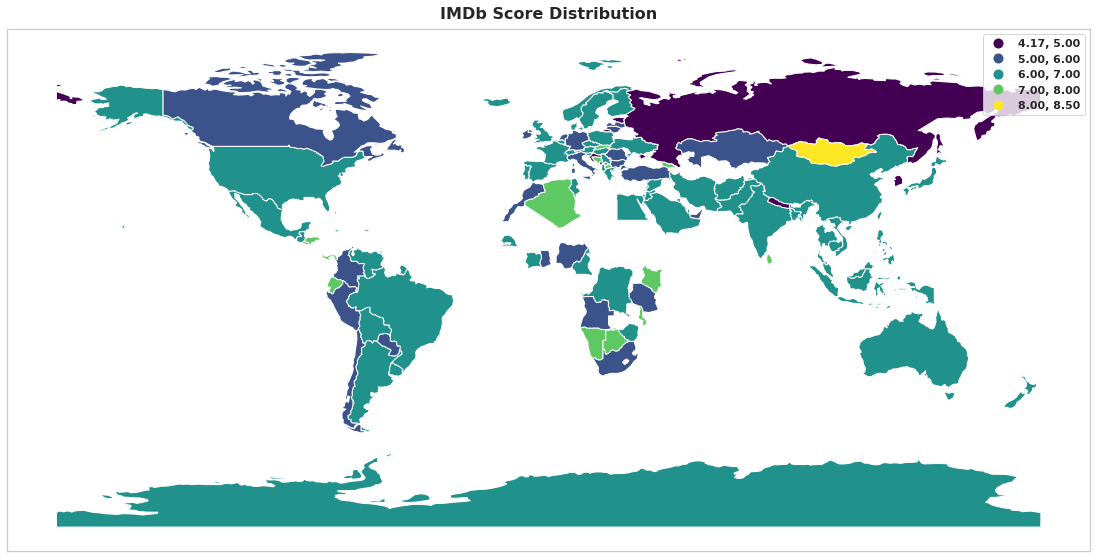

In [61]:
#Map plot
plt_df.plot(column = plt_df['Average IMDb Score'],legend=True,scheme='userdefined',classification_kwds={'bins': bins},cmap=colormap)
plt.title('IMDb Score Distribution',font,loc='center',pad=10,y=1.0)

#hide axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig = plt.gcf() 
fig.tight_layout()
fig.set_size_inches(16,12)

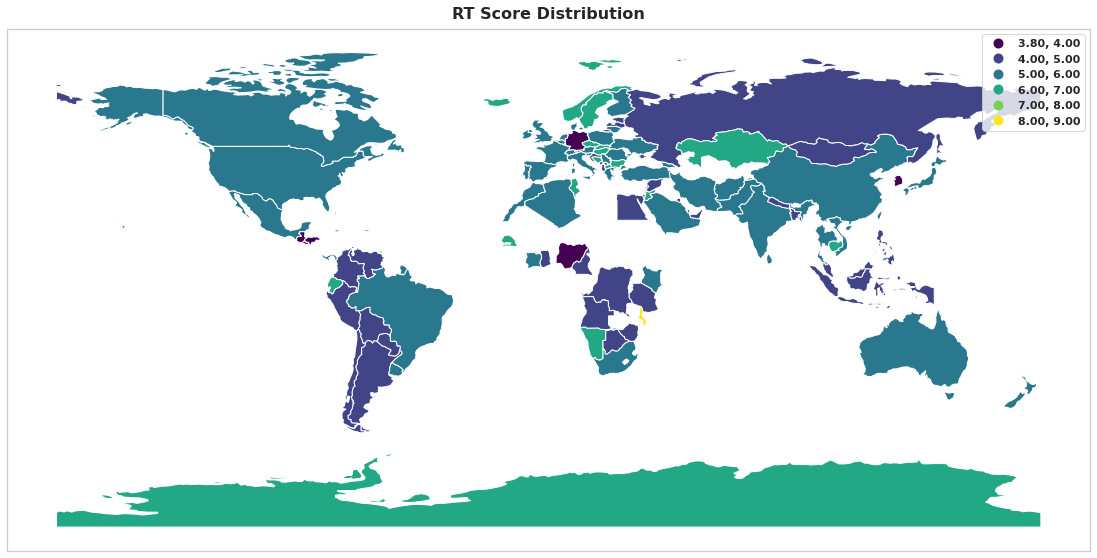

In [62]:
#Map plot
plt_df.plot(column = plt_df['Average Rotten Tomatoes Score'],legend=True,scheme='userdefined',classification_kwds={'bins': bins1},cmap=colormap)
plt.title('RT Score Distribution',font,loc='center',pad=10,y=1.0)

#Hide axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig = plt.gcf() 
fig.tight_layout()
fig.set_size_inches(16,12)

This EDA project began prior to the last dataset update (2021-12), which brought about significant changes. As such, results may be deprecated.
I would like to thank Ruchi Bhatia for his effort in making this data available, as well as all other contributors.